In [7]:
%matplotlib inline

# import resource 
# resource.setrlimit(resource.RLIMIT_NOFILE, (1000, -1))
# import basic functionality / libs
import sys
import os
import numpy as np
import pandas as pd
import json
import scipy
import pickle

# Import magic commands for jupyter notebook 
# - autoreloading a module
# - profiling functions for memory usage and scripts
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
%load_ext memory_profiler

sys.path.append('../../../')
# import fragility related modules
import dnn
from dnn.base.utils.log_error import initialize_logger
from dnn.base.constants.config import Config
# from dnn.io.loadsimdataset import LoadSimDataset
# from dnn.io.loadresults import LoadResults

# import basic plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# set configurations
patient = 'id001_bt'
patients = ['id001_ac', 'id002_cj', 'id008_gc', 'id010_js', 'id011_ml', 'id012_pc', 'id013_pg']
patient = 'id013_pg'
output_folder = os.path.join(os.path.expanduser("~"), 'Documents', 'figures', 
        'exp001-008_dnn', patient)

# where to find the raw data for this patient
rawdatadir = os.path.join('/Volumes/ADAM LI/rawdata/old/',  patient)

# which experimental set up do we want to compare with?
expname = 'exp001'

# real data results directory
resultsdir = os.path.join('/Volumes/ADAM LI/pydata/', 'dnn/output/', expname, patient)

# configuration and plotting
config = Config(output_base=output_folder) 
config.figures.MATPLOTLIB_BACKEND="qt5" #"Qt4Agg" #"inline"
config.figures.SHOW_FLAG=True

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


# Load In Training Regimens (Version001-007)

Performing the baseline test on the experimental data using a 12-layer VGG style CNN, we did various parameterizations:

Used all patients in a pooled train/test split of 70/30. Used patients: id001_ac, cj, gc, js, ml, pc, pg (N=7)

/network_hyperparameter_search/

- version1 = featurewise z-normalization only. overfit to training_data
- version2 = added unbalanced loss function
- version3 = added samplewise normalization 
- version4 = no samplewise normalization
- version5 = adding rotation and shifts at random
- version6 = added channel shifts and preprocess img with noise
- version7 = feature/sample normalization, rotation 5 degrees, width/height shifts, channel shifts among freq badns, and preprocess function



In [33]:
network_param_dir = os.path.join('/Volumes/ADAM LI/pydata/',
                    'dnn/output/network_hyperparameter_search/')
train_vers = [d for d in os.listdir(network_param_dir)]
print(train_vers)
print(os.listdir(network_param_dir))

loss = np.zeros((len(train_vers), 100))
acc = np.zeros(loss.shape)
val_acc = np.zeros(loss.shape)
val_loss = np.zeros(loss.shape)

# go through all patients
for idx, vers in enumerate(train_vers):
    # extract data from each training session
    histfile = os.path.join(network_param_dir, vers, 'history_2dcnn.pkl')
    print(histfile)
    # load in the history file
    with open(histfile, "rb") as f:
        history = pickle.load(f)
    print(history.keys())
    print(len(history['loss']))

    loss[idx, :] = history['loss'][:100]
    acc[idx, :] = history['acc'][:100]
    val_acc[idx,:] = history['val_acc'][:100]
    val_loss[idx,:] = history['val_loss'][:100]

['train_v1', 'train_v2', 'train_v3', 'train_v4', 'train_v5', 'train_v6', 'train_v7']
['train_v1', 'train_v2', 'train_v3', 'train_v4', 'train_v5', 'train_v6', 'train_v7']
/Volumes/ADAM LI/pydata/dnn/output/network_hyperparameter_search/train_v1/history_2dcnn.pkl
dict_keys(['val_loss', 'val_acc', 'lr', 'loss', 'acc'])
100
/Volumes/ADAM LI/pydata/dnn/output/network_hyperparameter_search/train_v2/history_2dcnn.pkl
dict_keys(['val_acc', 'acc', 'val_loss', 'lr', 'loss'])
100
/Volumes/ADAM LI/pydata/dnn/output/network_hyperparameter_search/train_v3/history_2dcnn.pkl
dict_keys(['acc', 'loss', 'lr', 'val_acc', 'val_loss'])
100
/Volumes/ADAM LI/pydata/dnn/output/network_hyperparameter_search/train_v4/history_2dcnn.pkl
dict_keys(['loss', 'val_loss', 'acc', 'lr', 'val_acc'])
100
/Volumes/ADAM LI/pydata/dnn/output/network_hyperparameter_search/train_v5/history_2dcnn.pkl
dict_keys(['loss', 'val_acc', 'acc', 'val_loss', 'lr'])
100
/Volumes/ADAM LI/pydata/dnn/output/network_hyperparameter_search/train

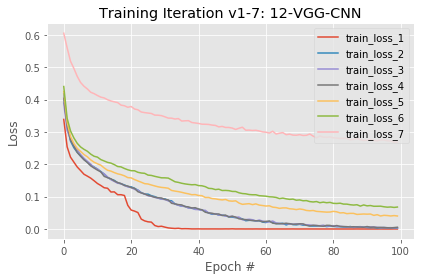

In [37]:
# plot the training loss and accuracy
N = np.arange(0, loss.shape[1])
plt.style.use("ggplot")

plt.figure()
for idx in range(len(train_vers)):
    plt.plot(N, loss[idx,:], label="train_loss_{}".format(idx+1))
    plt.title("Training Iteration v1-7: 12-VGG-CNN")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend()
plt.tight_layout()
plt.show()
    
#     plt.plot(N, val_loss, label="test_loss")
#     plt.plot(N, acc, label="train_acc")
#     plt.plot(N, val_acc, label="test_acc")
    


# Load in Actual Experiments (exp001-005)

- exp001 = 

In [26]:
print(expname)
loss = np.zeros((len(patients), 300))
acc = np.zeros(loss.shape)
val_acc = np.zeros(loss.shape)
val_loss = np.zeros(loss.shape)

# go through all patients
for idx, pat in enumerate(patients):
    # real data results directory
    resultsdir = os.path.join('/Volumes/ADAM LI/pydata/', 'dnn/output/', expname, pat)
    resultfiles = [f for f in os.listdir(resultsdir) if f.endswith('.pkl')]
    
    # extract data from each training session
    for _file in resultfiles:
        histfile = os.path.join(resultsdir, _file)

        # load in the history file
        with open(histfile, "rb") as f:
            history = pickle.load(f)
        print(history.keys())
        print(len(history['loss']))
        
        loss[idx, :] = history['loss']
        acc[idx, :] = history['acc']
        val_acc[idx,:] = history['val_acc']
        val_loss[idx,:] = history['val_loss']

exp001
/Volumes/ADAM LI/pydata/dnn/output/exp001/id001_ac
dict_keys(['val_acc', 'loss', 'val_loss', 'acc'])
300
/Volumes/ADAM LI/pydata/dnn/output/exp001/id002_cj
dict_keys(['val_acc', 'loss', 'acc', 'val_loss'])
300
/Volumes/ADAM LI/pydata/dnn/output/exp001/id008_gc
dict_keys(['acc', 'val_loss', 'val_acc', 'loss'])
300
/Volumes/ADAM LI/pydata/dnn/output/exp001/id010_js
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
300
/Volumes/ADAM LI/pydata/dnn/output/exp001/id011_ml
dict_keys(['loss', 'val_loss', 'val_acc', 'acc'])
300
/Volumes/ADAM LI/pydata/dnn/output/exp001/id012_pc
dict_keys(['val_loss', 'loss', 'acc', 'val_acc'])
300
/Volumes/ADAM LI/pydata/dnn/output/exp001/id013_pg
dict_keys(['loss', 'acc', 'val_acc', 'val_loss'])
300
